# Multiple-strain Disease Model with Vaccination

In [1]:
using AlgebraicPetri, AlgebraicPetri.TypedPetri
using Catlab.Programs, Catlab.Graphics
using Catlab.CategoricalAlgebra
using Catlab.WiringDiagrams
using DisplayAs, Markdown

This example presents models incorporating multiple strains of disease and vaccine type.
Importantly, it shows why stratification by disease strain is different from other stratifications, e.g. geography or age, and requires using a different type system.
If you are unfamiliar with stratification, we recommend first reading the stratification tutorial.

## Define basic type system

We start by defining our basic type system, $P_{infectious}$ for infectious disease models.

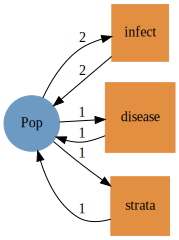

In [2]:
const infectious_ontology = LabelledPetriNet(
  [:Pop],
  :infect => ((:Pop, :Pop) => (:Pop, :Pop)),
  :disease => (:Pop => :Pop),
  :strata => (:Pop => :Pop)
)

to_graphviz(infectious_ontology)

We define a simple SIR model with reflexive transitions typed as "strata" to indicate which stratified
states will interact with transitions amongst strata.

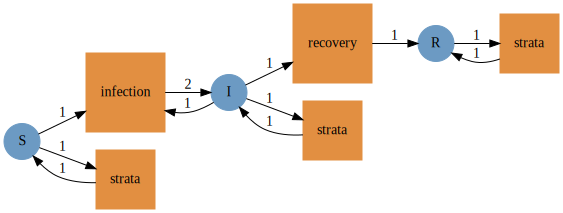

In [3]:
sir_uwd = @relation (S,I,R) where (S::Pop, I::Pop, R::Pop) begin
  infect(S, I, I, I)
  disease(I, R)
end

sir_model = oapply_typed(infectious_ontology, sir_uwd, [:infection, :recovery])
sir_model = add_reflexives(sir_model, [[:strata], [:strata], [:strata]], infectious_ontology)

to_graphviz(dom(sir_model))

## Define a model of multiple vaccine types

We also define a model of vaccination with multiple vaccine types, typed over $P_{infectious}$.
Each stratum has reflexive "disease" transitions. Transitions which represent the administration
of a vaccine to an individual are typed as "strata". Infection transitions between individuals of different
vaccination status is possible (i.e.; we do not assume a perfect vaccine).

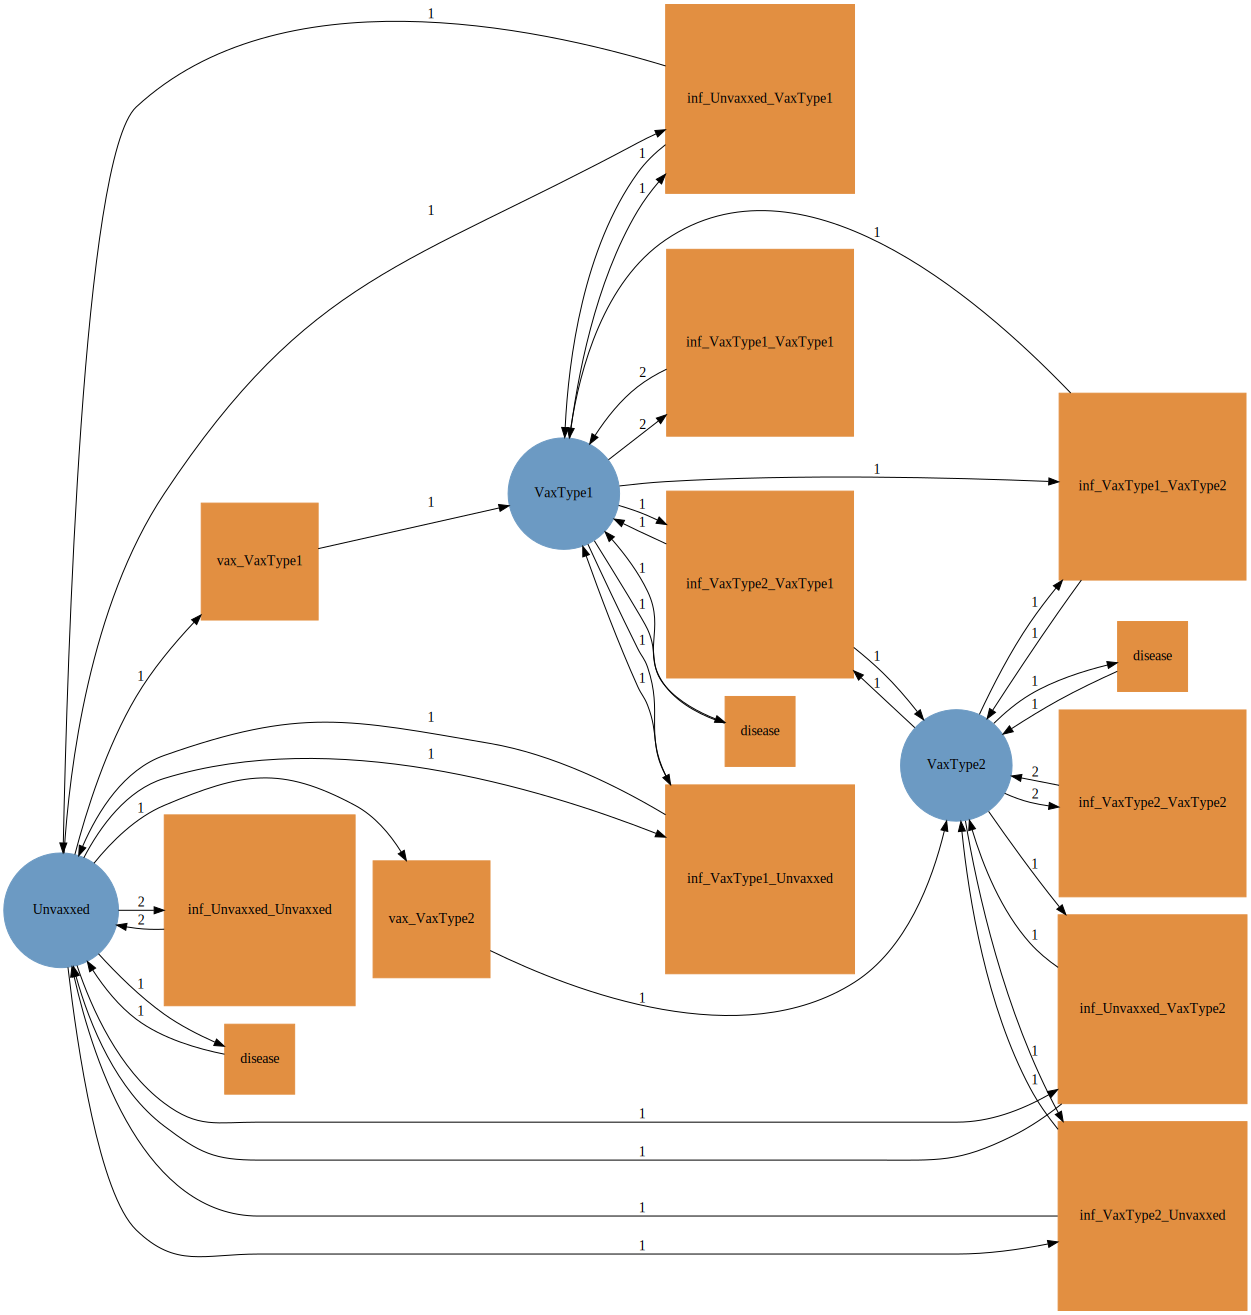

In [4]:
function vax_model(n)
  uwd = RelationDiagram(repeat([:Pop], n+1))

  variable = :Unvaxxed
  junction = add_junction!(uwd, :Pop, variable=variable)
  port = ports(uwd, outer=true)[1]
  set_junction!(uwd, port, junction, outer=true)
  junctions = Dict(variable => junction)
  for i in 1:n
    variable = Symbol("VaxType$(i)")
    junction = add_junction!(uwd, :Pop, variable=variable)
    port = ports(uwd, outer=true)[i+1]
    set_junction!(uwd, port, junction, outer=true)
    junctions[variable] = junction
  end

  strains = filter((x) -> x != Symbol("Unvaxxed"), keys(junctions))
  for s in strains
    pair = (:Unvaxxed, s)
    box = add_box!(uwd, [junction_type(uwd, junctions[p]) for p in pair], name=:strata)
    for (rgn, port) in zip(pair, ports(uwd, box))
      set_junction!(uwd, port, junctions[rgn])
    end
  end
  tnames = [Symbol("vax_$(b)") for b in strains]

  pairs = collect(Iterators.product(keys(junctions), keys(junctions)))
  for pair in pairs
    ins_outs = (pair[1], pair[2], pair[1], pair[2])
    box = add_box!(uwd, [junction_type(uwd, junctions[p]) for p in ins_outs], name=:infect)
    for (rgn, port) in zip(ins_outs, ports(uwd, box))
      set_junction!(uwd, port, junctions[rgn])
    end
    push!(tnames,Symbol("inf_$(pair[1])_$(pair[2])"))
  end
  act = oapply_typed(infectious_ontology, uwd, tnames)
  add_reflexives(act, repeat([[:disease]], n+1), infectious_ontology)
end

to_graphviz(dom(vax_model(2)))

## Stratify the SIR model with vaccinations for two vaccine types

We can now stratify the two typed models to get a model of SIR with vaccination by multiple possible vaccine types.

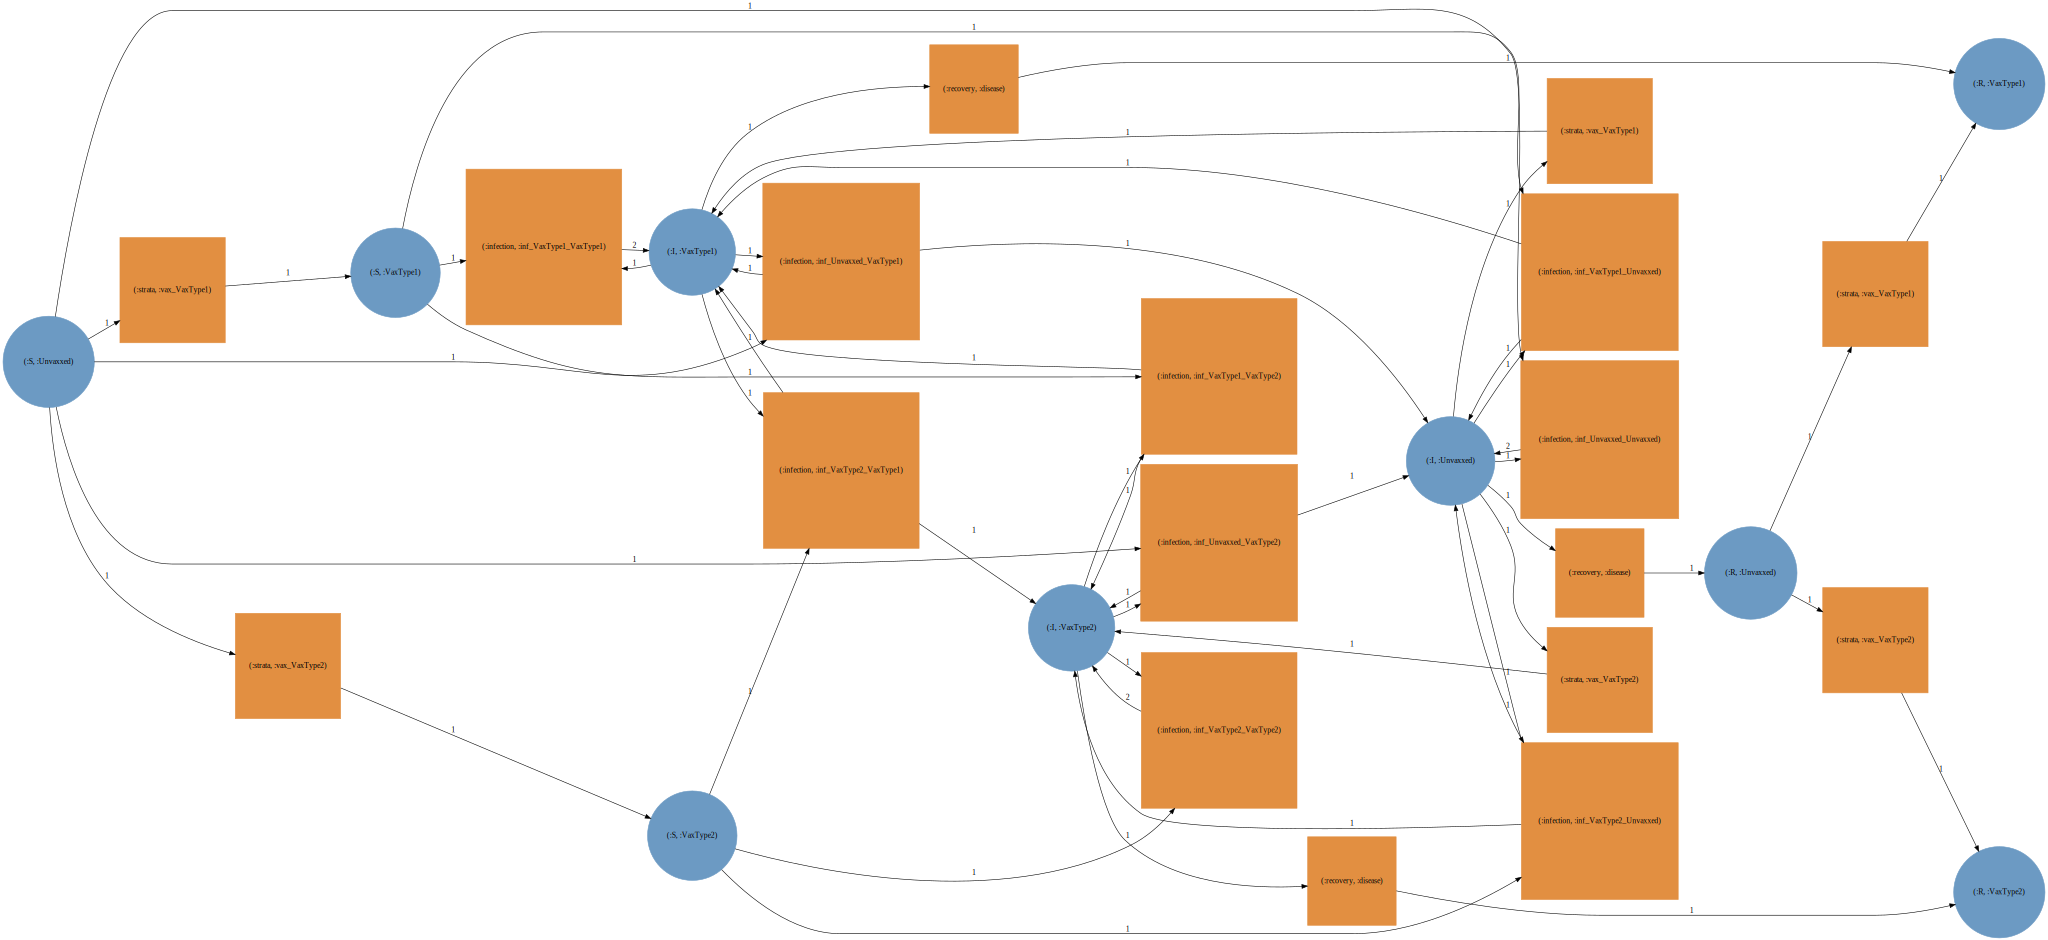

In [5]:
typed_product(sir_model, vax_model(2)) |> dom |> to_graphviz

## Define a model of multiple disease strains

Here we define a model for multiple disease strains, typed by $P_{infectious}$.
In this model, uninfected individuals can become infected by individuals carrying one of the strains.
We add reflexive transitions of types `:disease` and `:strata` for the strain states but only `:strata` for the uninfected state,
because those individuals should only correspond to $S$ in the disease model.

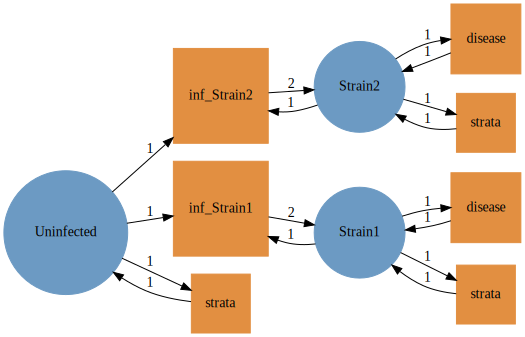

In [6]:
function strain_model′(n)
  uwd = RelationDiagram(repeat([:Pop], n+1))
  variable = :Uninfected
  junction = add_junction!(uwd, :Pop, variable=variable)
  port = ports(uwd, outer=true)[1]
  set_junction!(uwd, port, junction, outer=true)
  junctions = Dict(variable => junction)
  for i in 1:n
    variable = Symbol("Strain$(i)")
    junction = add_junction!(uwd, :Pop, variable=variable)
    port = ports(uwd, outer=true)[i+1]
    set_junction!(uwd, port, junction, outer=true)
    junctions[variable] = junction
  end
  strains = filter((x) -> x != Symbol("Uninfected"), keys(junctions))
  for s in strains
    pair = (:Uninfected, s, s, s)
    box = add_box!(uwd, [junction_type(uwd, junctions[p]) for p in pair], name=:infect)
    for (rgn, port) in zip(pair, ports(uwd, box))
      set_junction!(uwd, port, junctions[rgn])
    end
  end
  act = oapply_typed(infectious_ontology, uwd, [Symbol("inf_$(b)") for b in strains])
  add_reflexives(act, vcat([[:strata]],repeat([[:disease,:strata]], n)), infectious_ontology)
end

to_graphviz(dom(strain_model′(2)))

## Stratify the SIRD model for two strains

Unfortunately, stratification of these models does not produce the desired result, leading
to many states and transitions. The problem is that it does not make sense for the
uninfected population to be stratified over the full set of states of the SIRD model
(i.e.; uninfected persons can never have any disease state other than "S").
This is due to the fact that there is only one type of place in $P_{infectious}$, so instead
the pullback of places simply becomes the product.

We can address this by changing the type system to include multiple place types.

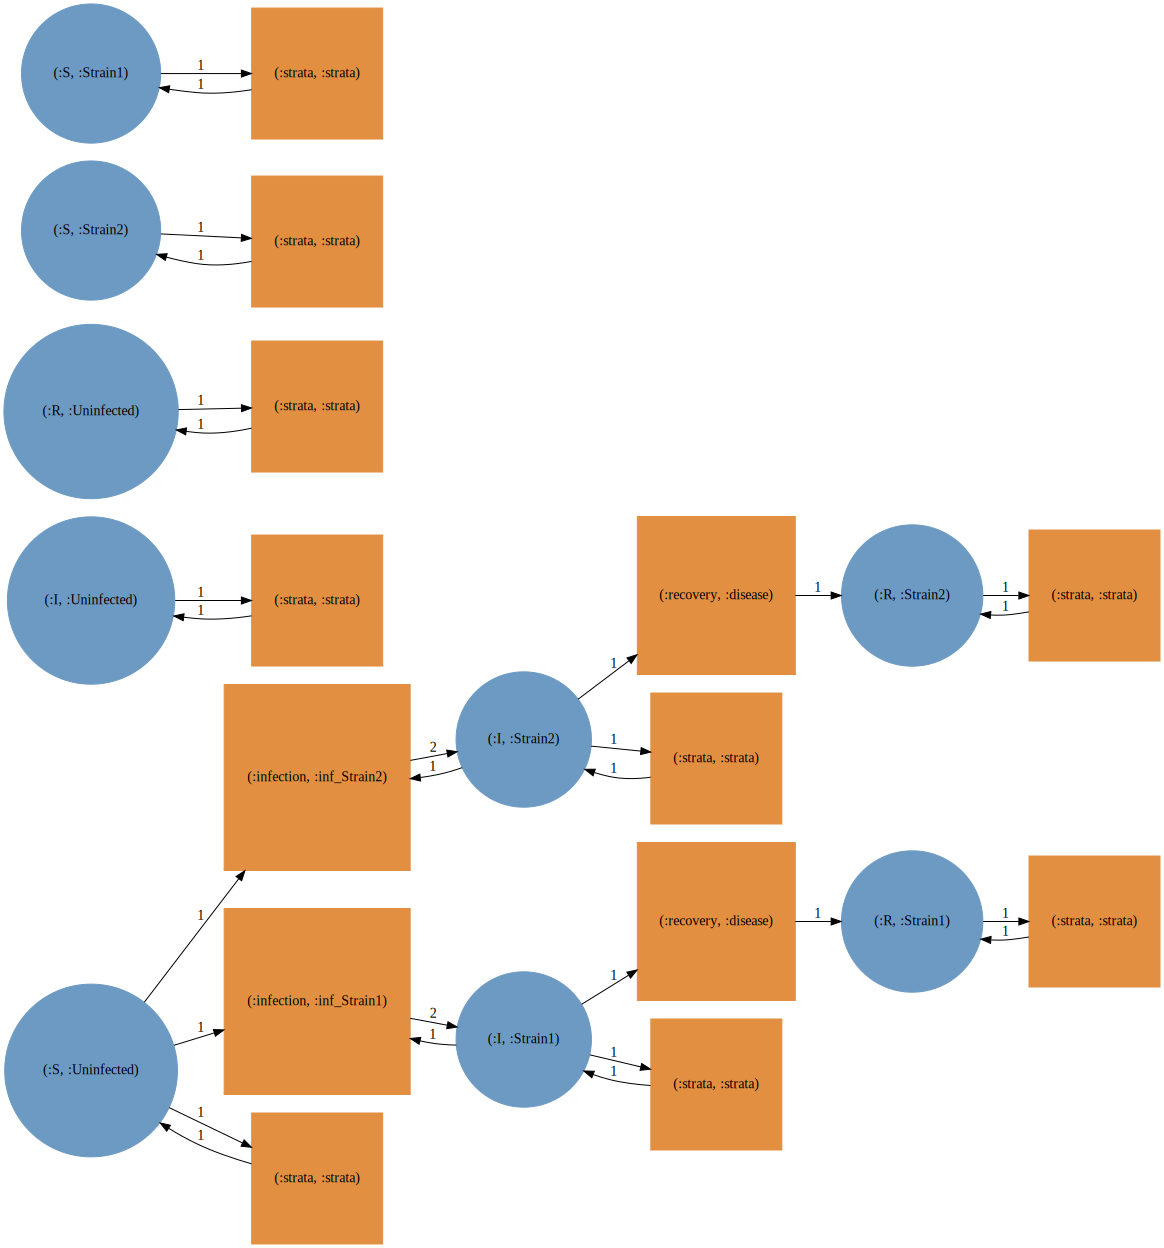

In [7]:
typed_product(sir_model, strain_model′(2)) |> dom |> to_graphviz

## Define a new type system and corresponding disease and multi-strain models

The new type system has separate states for uninfected and infected to account for the asymmetry in their role in infection
and for the corresponding asymmetry in the intended stratification.
Accordingly, the `:Inf` state has `:disease` and `:strataI` transitions.
The `:Uninf` state has a `:strataU` transition, but no `:disease` transition.
We denote the new type system by $P_{strain}$.

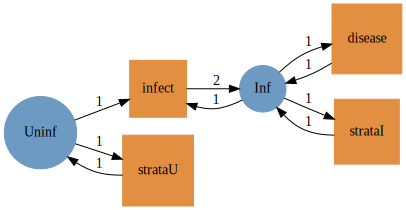

In [8]:
const strain_ontology = LabelledPetriNet(
  [:Uninf, :Inf],
  :infect => ((:Uninf, :Inf) => (:Inf, :Inf)),
  :disease => (:Inf => :Inf),
  :strataI => (:Inf => :Inf),
  :strataU => (:Uninf => :Uninf)
)

to_graphviz(strain_ontology)

We now recreate the SIR model using the new type system. Note that the `where` clause now specifies the differing
place types for each state.

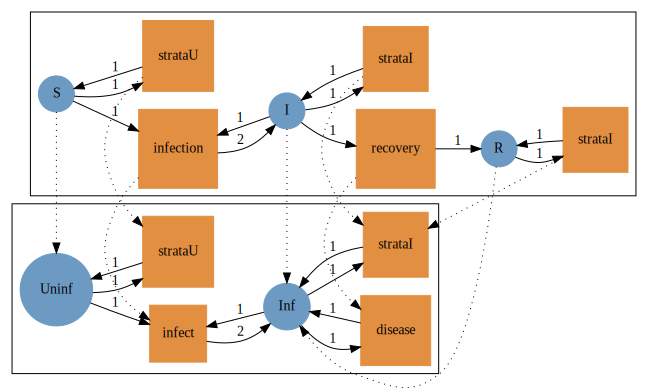

In [9]:
sir_for_strains_uwd = @relation (S,I,R) where (S::Uninf, I::Inf, R::Inf) begin
  infect(S, I, I, I)
  disease(I, R)
end
sir_for_strains_model = oapply_typed(strain_ontology, sir_for_strains_uwd, [:infection, :recovery])
sir_for_strains_model = add_reflexives(sir_for_strains_model, [[:strataU], [:strataI], [:strataI]], strain_ontology)

to_graphviz(sir_for_strains_model)

And similarly reform the multi-strain model.

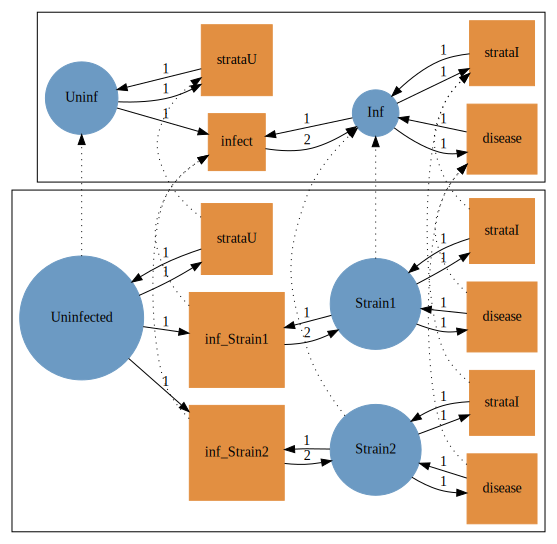

In [10]:
function strain_model(n)
  uwd = RelationDiagram(vcat([:Uninf],repeat([:Inf], n)))
  variable = :Uninfected
  junction = add_junction!(uwd, :Uninf, variable=variable)
  port = ports(uwd, outer=true)[1]
  set_junction!(uwd, port, junction, outer=true)
  junctions = Dict(variable => junction)
  for i in 1:n
    variable = Symbol("Strain$(i)")
    junction = add_junction!(uwd, :Inf, variable=variable)
    port = ports(uwd, outer=true)[i+1]
    set_junction!(uwd, port, junction, outer=true)
    junctions[variable] = junction
  end
  strains = filter((x) -> x != Symbol("Uninfected"), keys(junctions))
  for s in strains
    pair = (:Uninfected, s, s, s)
    box = add_box!(uwd, [junction_type(uwd, junctions[p]) for p in pair], name=:infect)
    for (rgn, port) in zip(pair, ports(uwd, box))
      set_junction!(uwd, port, junctions[rgn])
    end
  end
  act = oapply_typed(strain_ontology, uwd, [Symbol("inf_$(b)") for b in strains])
  add_reflexives(act, vcat([[:strataU]],repeat([[:disease,:strataI]], n)), strain_ontology)
end

to_graphviz(strain_model(2))

When we now stratify we get the desired model. Note however that there are extraneous "strata"
transitions; this is because there were no non-trivial stratum transitions in either input typed Petri net.
(note that only "disease" and "infect" transition types were needed to fully define the multiple strain dynamics).

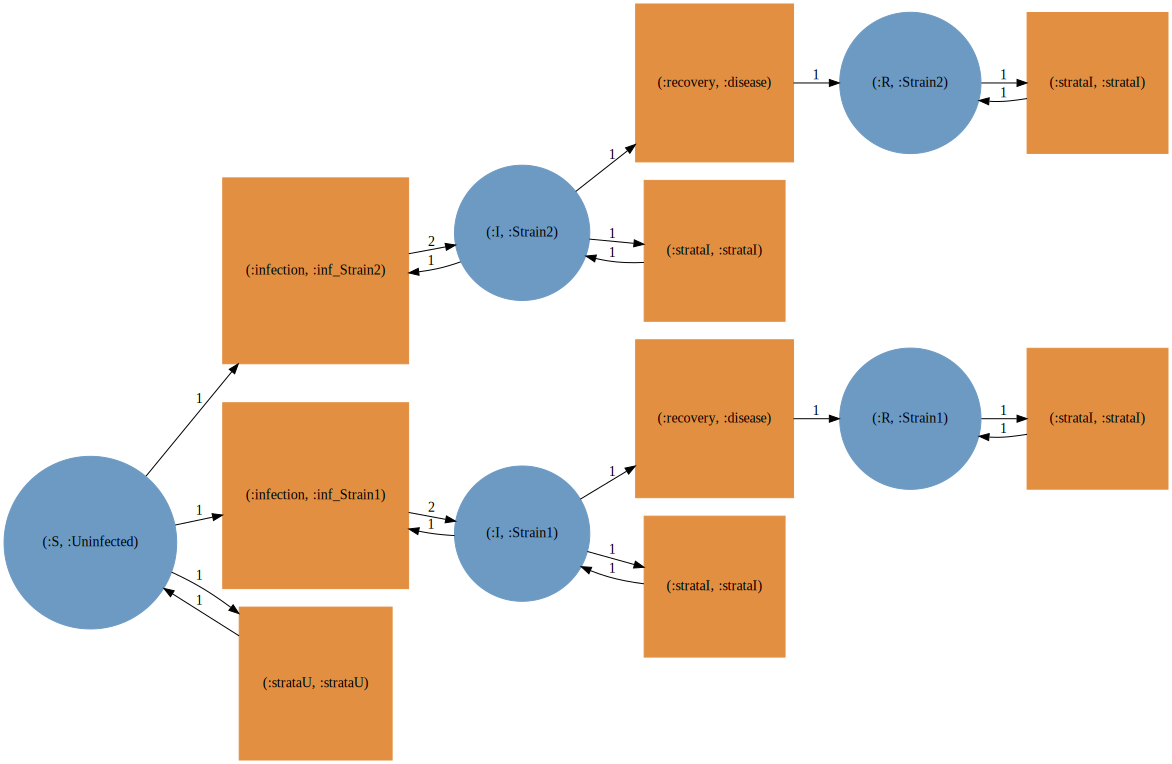

In [11]:
sir_strain = typed_product(sir_for_strains_model, strain_model(2))

to_graphviz(dom(sir_strain))

## Post-composition: Retyping the type system

In some instances, we may want to relate models typed to different type systems.
For example, we usually type our `simple_trip` model of geographic regions to the `infectious_ontology` such that we can stratify a disease model by geographic regions,
but the multi-strain disease model above is typed by the new `strain_ontology`.

Crucially, we can accomplish this *if* there is an appropriate morphism (map) between the type systems
because post-composition by a morphism of type systems is functorial.
In this case, there is a morphism from `strain_ontology` to `infectious_ontology` ($P_{strain} \to P_{infectious}$),
so we will be able to "switch" type systems.

### Morphism from `strain_ontology` to `infectious_ontology`

We use `oapply_typed` on a UWD representation of the `strain_ontology`, but note that we could also directly
define the map using `ACSetTransformation`. The result is a morphism $P_{strain}\to P_{infectious}$.

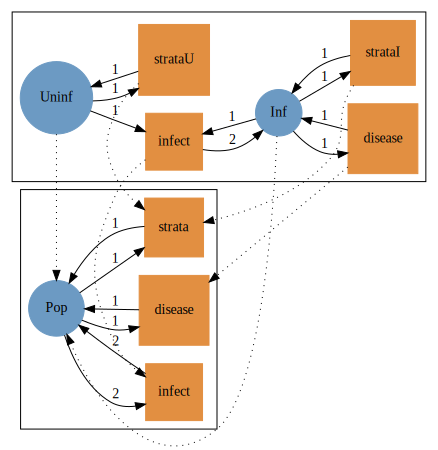

In [12]:
strain_ont_uwd = @relation (Uninf,Inf) where (Uninf::Pop, Inf::Pop) begin
  infect(Uninf, Inf, Inf, Inf)
  disease(Inf, Inf)
  strata(Inf, Inf)
  strata(Uninf, Uninf)
end
strain_ont_act = oapply_typed(infectious_ontology,strain_ont_uwd,[:infect,:disease,:strataI,:strataU])

to_graphviz(strain_ont_act)

### Define simple-trip model between $N$ regions

To demonstrate stratification utilizing post-composition to re-type the models, we use the simple-trip geographic model,
defined fully in the stratification tutorial.
It is typed by `infectious_ontology` ($P_{infectious}$).

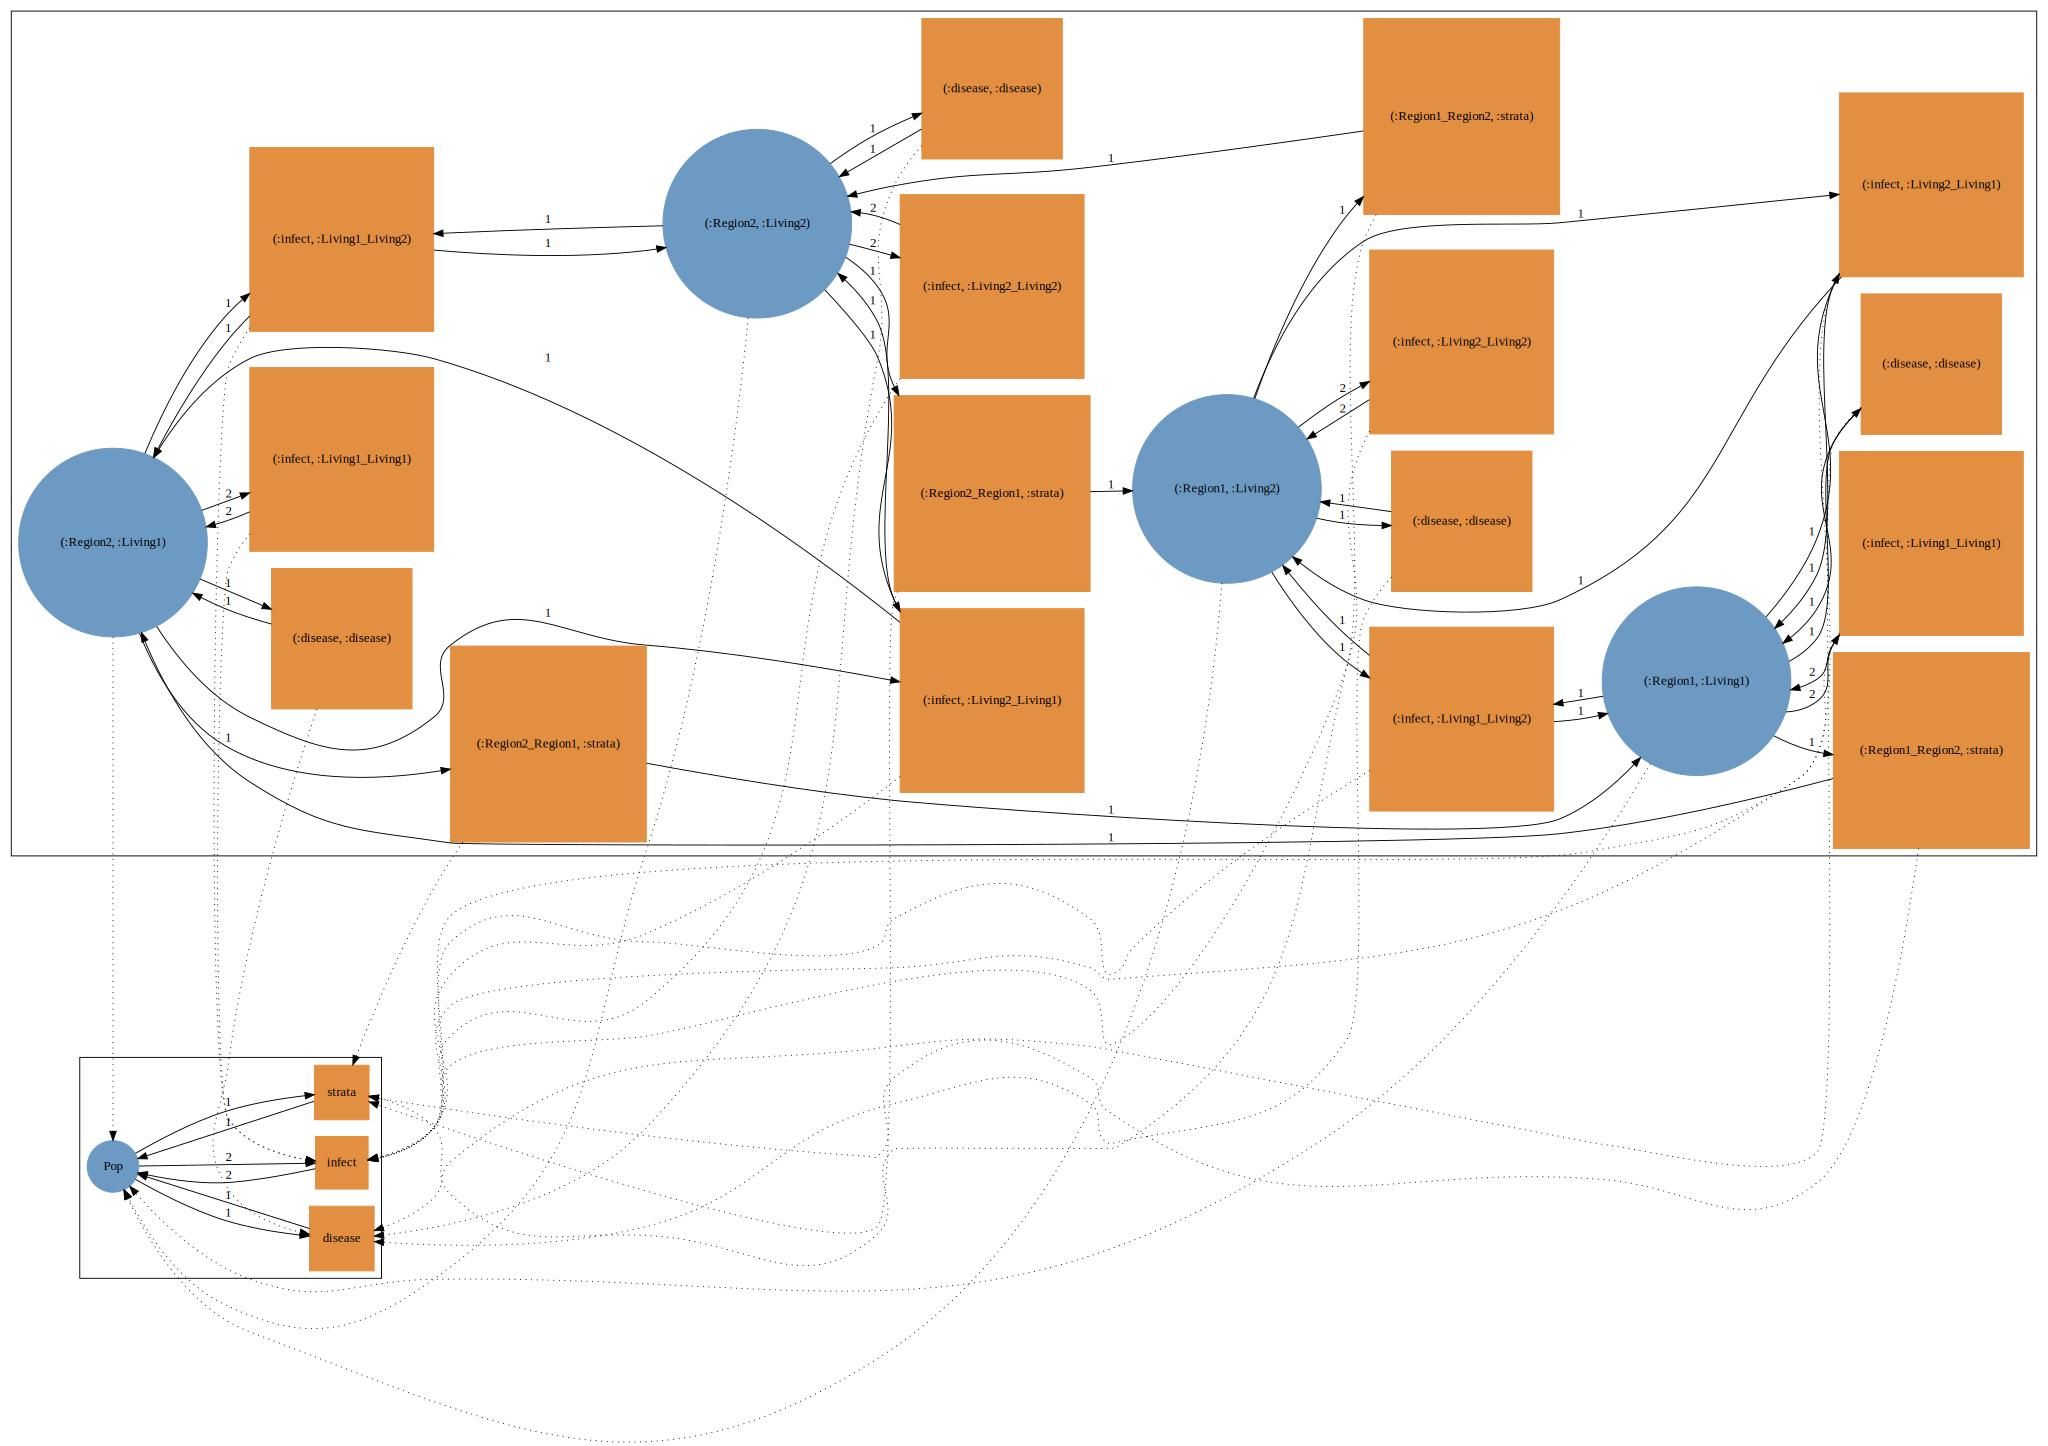

In [13]:
function travel_model(n)
  uwd = RelationDiagram(repeat([:Pop], n))
  junctions = Dict(begin
    variable = Symbol("Region$(i)")
    junction = add_junction!(uwd, :Pop, variable=variable)
    set_junction!(uwd, port, junction, outer=true)
    variable => junction
  end for (i, port) in enumerate(ports(uwd, outer=true)))

  pairs = filter(x -> first(x) != last(x), collect(Iterators.product(keys(junctions), keys(junctions))))
  for pair in pairs
    box = add_box!(uwd, [junction_type(uwd, junctions[p]) for p in pair], name=:strata)
    for (rgn, port) in zip(pair, ports(uwd, box))
      set_junction!(uwd, port, junctions[rgn])
    end
  end

  act = oapply_typed(infectious_ontology, uwd, [Symbol("$(a)_$(b)") for (a, b) in pairs])
  add_reflexives(act, repeat([[:infect, :disease]], n), infectious_ontology)
end

function living_model(n)
  typed_living = pairwise_id_typed_petri(infectious_ontology, :Pop, :infect, [Symbol("Living$(i)") for i in 1:n])
  add_reflexives(typed_living, repeat([[:disease, :strata]], n), infectious_ontology)
end

simple_trip_model = typed_product(travel_model(2), living_model(2))

to_graphviz(simple_trip_model)

### Stratify multi-strain SIR and simple-trip models

If we want to use the simple trip model to stratify our multi-strain SIR model, we have a problem
because the multi-strain SIR model is typed over $P_{strain}$, that is, it is a morphism $\phi : P \to P_{strain}$.
Therefore, we can compose with the morphism `strain_ont_act` ($P_{strain}\to P_{infectious}$) we made earlier, to get
a new morphism from $P \to P_{infectious}$.

In [14]:
sir_strain_retyped = compose(sir_strain,strain_ont_act)

ACSetTransformation((T = compose(compose(compose(FinFunction([1, 6, 13, 17, 24, 25, 27, 34, 35], 9, 35), FinFunction(#57, FinSet(35), FinSet(5))), FinFunction([1, 2, 4, 3, 3], 5, 4)), FinFunction([1, 2, 3, 3], 4, 3)), S = compose(compose(compose(FinFunction([1, 5, 6, 8, 9], 5, 9), FinFunction(#57, FinSet(9), FinSet(3))), FinFunction([1, 2, 2], 3, 2)), FinFunction([1, 1], 2, 1)), I = compose(compose(compose(FinFunction([1, 8, 13, 20, 28, 33, 41, 42, 45, 53, 54], 11, 54), FinFunction(#57, FinSet(54), FinSet(6))), FinFunction([1, 2, 3, 5, 4, 4], 6, 5)), FinFunction([1, 2, 3, 4, 4], 5, 4)), O = compose(compose(compose(FinFunction([1, 8, 13, 20, 28, 33, 41, 42, 45, 53, 54], 11, 54), FinFunction(#57, FinSet(54), FinSet(6))), FinFunction([1, 2, 3, 5, 4, 4], 6, 5)), FinFunction([1, 2, 3, 4, 4], 5, 4)), Name = Catlab.CategoricalAlgebra.FinSets.LooseVarFunction{Tuple{Symbol, Symbol}, Symbol}(FinDomFunction(Union{ACSets.ColumnImplementations.AttrVar, Symbol}[], FinSet(0), TypeSet(Union{ACSets.Col

We can now take the typed product to get the multi-strain SIR model stratified over the simple trip model
of movement between different regions.

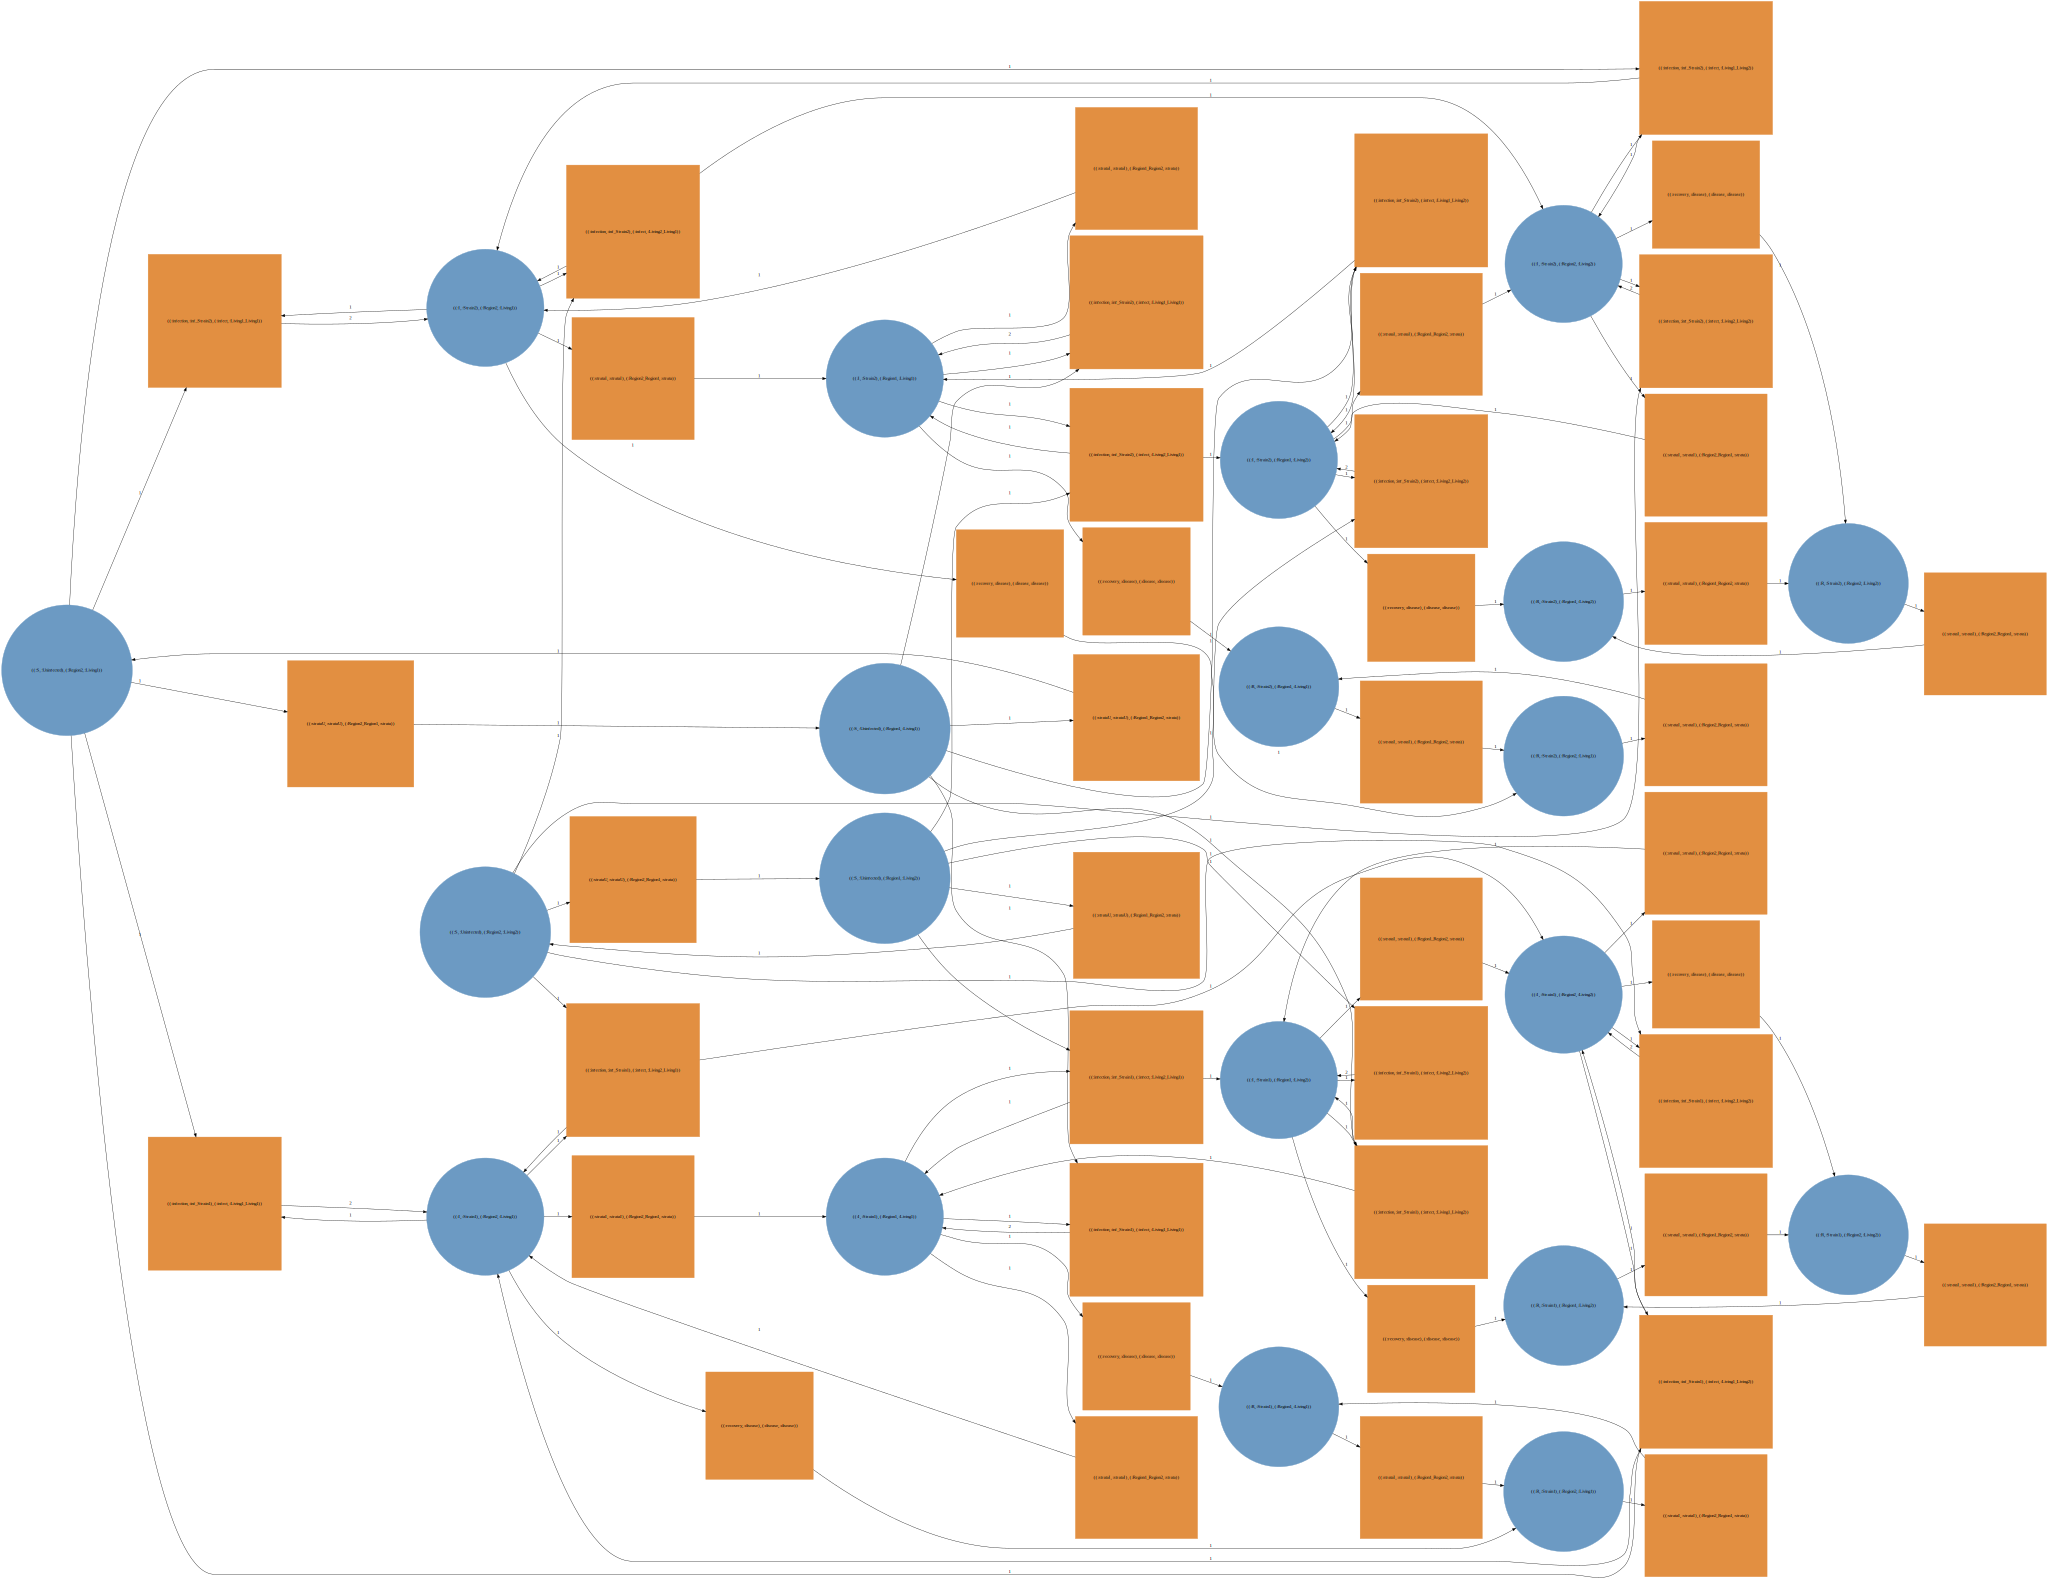

In [15]:
sir_strain_trip = typed_product(sir_strain_retyped,simple_trip_model)

to_graphviz(dom(sir_strain_trip))

## Define a multi-strain SIR model with vaccination by multiple vaccine types

Because the multi-vaccine model was typed according to $P_{infectious}$, our retyped
multi-strain SIR can be stratified according to the multiple vaccine model in a
similar way.

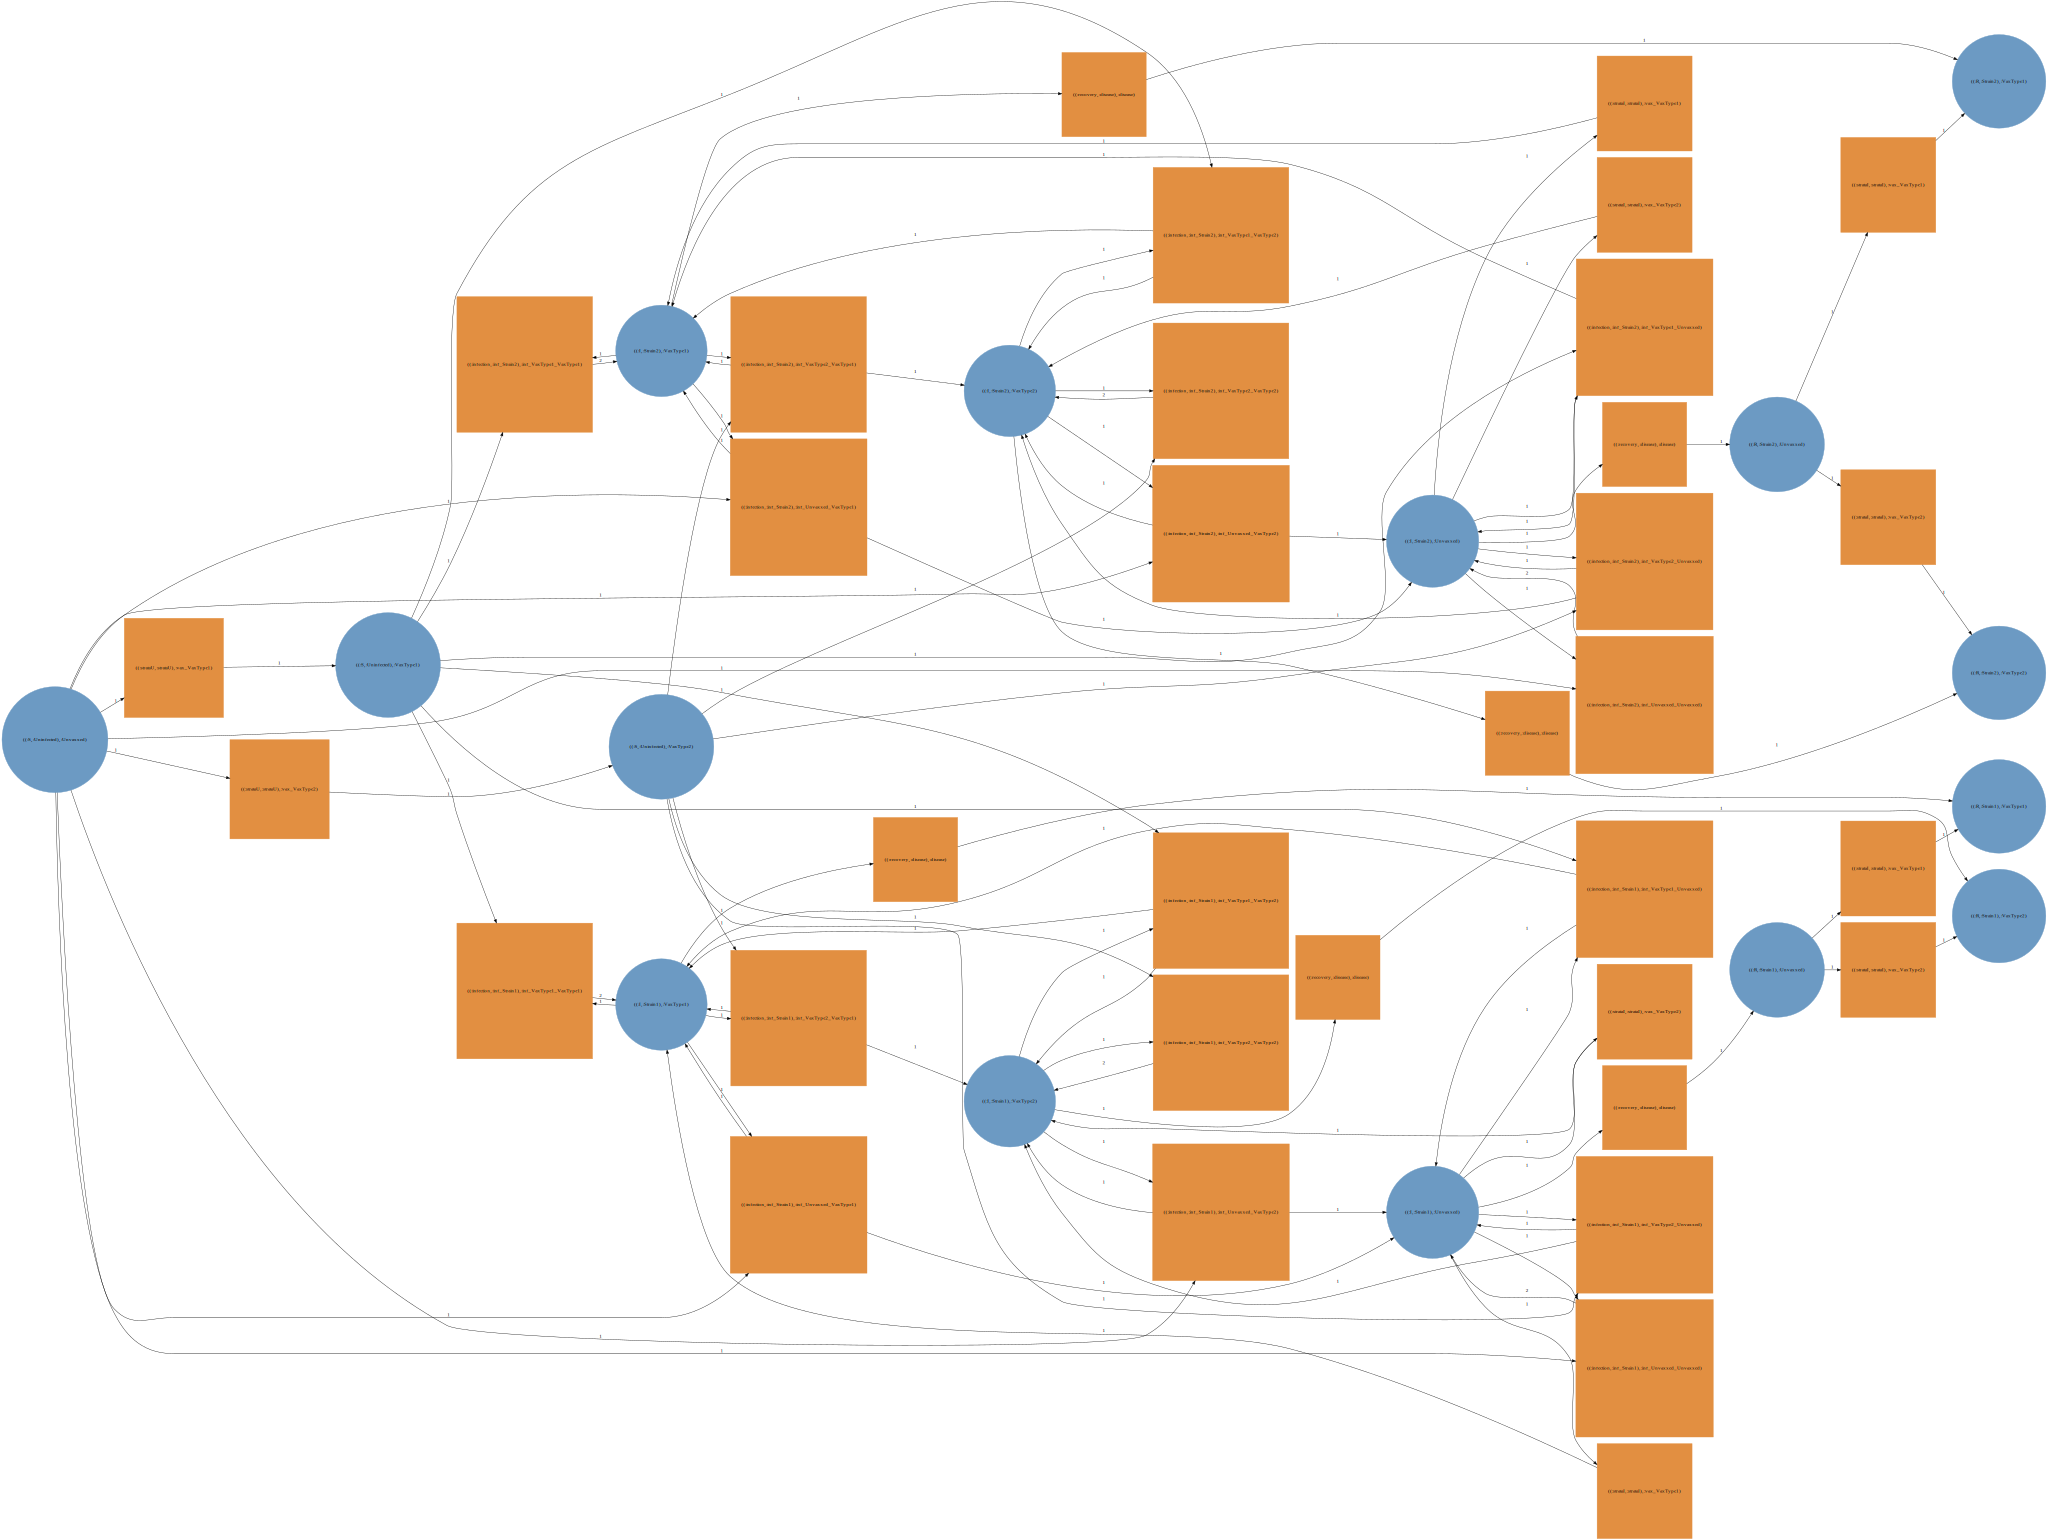

In [16]:
sir_strain_vax = typed_product(sir_strain_retyped,vax_model(2))

to_graphviz(dom(sir_strain_vax))

## Re-stratify the multi-strain multi-vax SIRD model with the simple trip model

If we would like to stratify our SIR-strain-vaccine model (`sir_strain_vax`) with the simple trip model,
we again face a difficulty. These two models are both typed by $P_{infectious}$, but
both the "vaccination" transitions of the first model and the "travel" transitions of the second
are currently typed to the `:strata` transition of the `infectious_ontology` type system.
Naively stratifying would thus produce transitions in which persons traveled and were vaccinated simultaneously.

To appropriately stratify, we need an additional "strata" transition to distinguish
between the two types of transitions.
We can again use post-compostion with the morphism between type systems to reuse our existing models.

### Define an augmented version of the `infectious_ontology` type system with an additional "strata" transition

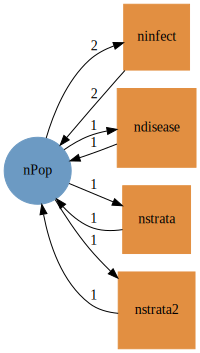

In [17]:
const aug_inf_ontology = LabelledPetriNet(
  [:nPop],
  :ninfect => ((:nPop, :nPop) => (:nPop, :nPop)),
  :ndisease => (:nPop => :nPop),
  :nstrata => (:nPop => :nPop),
  :nstrata2 => (:nPop => :nPop)
)

to_graphviz(aug_inf_ontology)

### Define morphisms from the original type system to the new augmented type system

We form one morphism that maps the `:strata` transition to `:nstrata`.
This morphism will serve to re-type the SIRD-strain-vax model.

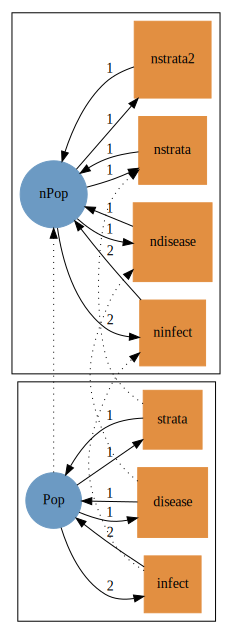

In [18]:
function retype_inf_ont(strata_map)
  uwd = RelationDiagram([:nPop])
  variable = :Pop
  junction = add_junction!(uwd, :nPop, variable=variable)
  port = ports(uwd, outer=true)[1]
  set_junction!(uwd, port, junction, outer=true)
  junctions = Dict(variable => junction)

  boxes = [:ninfect, :ndisease, strata_map]
  for bname in boxes
    if bname == :ninfect
      pair = (:Pop, :Pop, :Pop, :Pop)
    else
      pair = (:Pop, :Pop)
    end
    box = add_box!(uwd, [junction_type(uwd, junctions[p]) for p in pair], name=bname)
    for (rgn, port) in zip(pair, ports(uwd, box))
      set_junction!(uwd, port, junctions[rgn])
    end
  end

  act = oapply_typed(aug_inf_ontology, uwd, [:infect, :disease, :strata])
end

inf_ont_act = retype_inf_ont(:nstrata)

to_graphviz(inf_ont_act)

We form another morphism that maps the `:strata` transition to `:nstrata2`.
This morphism will serve to re-type the simple trip model.

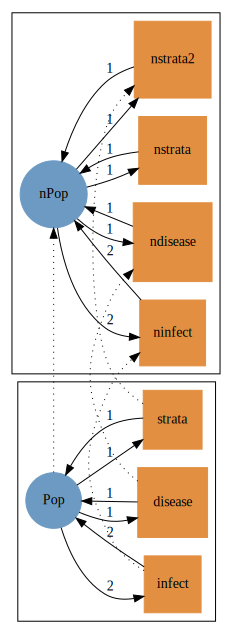

In [19]:
rgn_ont_act = retype_inf_ont(:nstrata2)

to_graphviz(rgn_ont_act)

### Add reflexive transitions

To finish preparing for stratification, we need to add the new reflexive transitions to the component models.
To the SIR-strain-vax model, we add an `:nstrata2` tranisiton to each state. Note that if the model
included a decreased (or any other immobile) state, we would not add a reflexive transition to them, as they cannot travel.

In [20]:
sir_strain_vax_retyped = flatten_labels(compose(sir_strain_vax,inf_ont_act))
reflx = [[:nstrata2]]
for ii in 2:ns(dom(sir_strain_vax_retyped))
    push!(reflx,[:nstrata2])
end
aug_sir_strain_vax = add_reflexives(sir_strain_vax_retyped, reflx, aug_inf_ontology);

To the simple trip model, we add an `:nstrata` tranisiton for each state.

In [21]:
simple_trip_retyped = flatten_labels(compose(simple_trip_model,rgn_ont_act))
aug_trip = add_reflexives(simple_trip_retyped, repeat([[:nstrata]],ns(dom(simple_trip_retyped))), aug_inf_ontology);

### Stratify the SIR-strain-vax and simple trip models

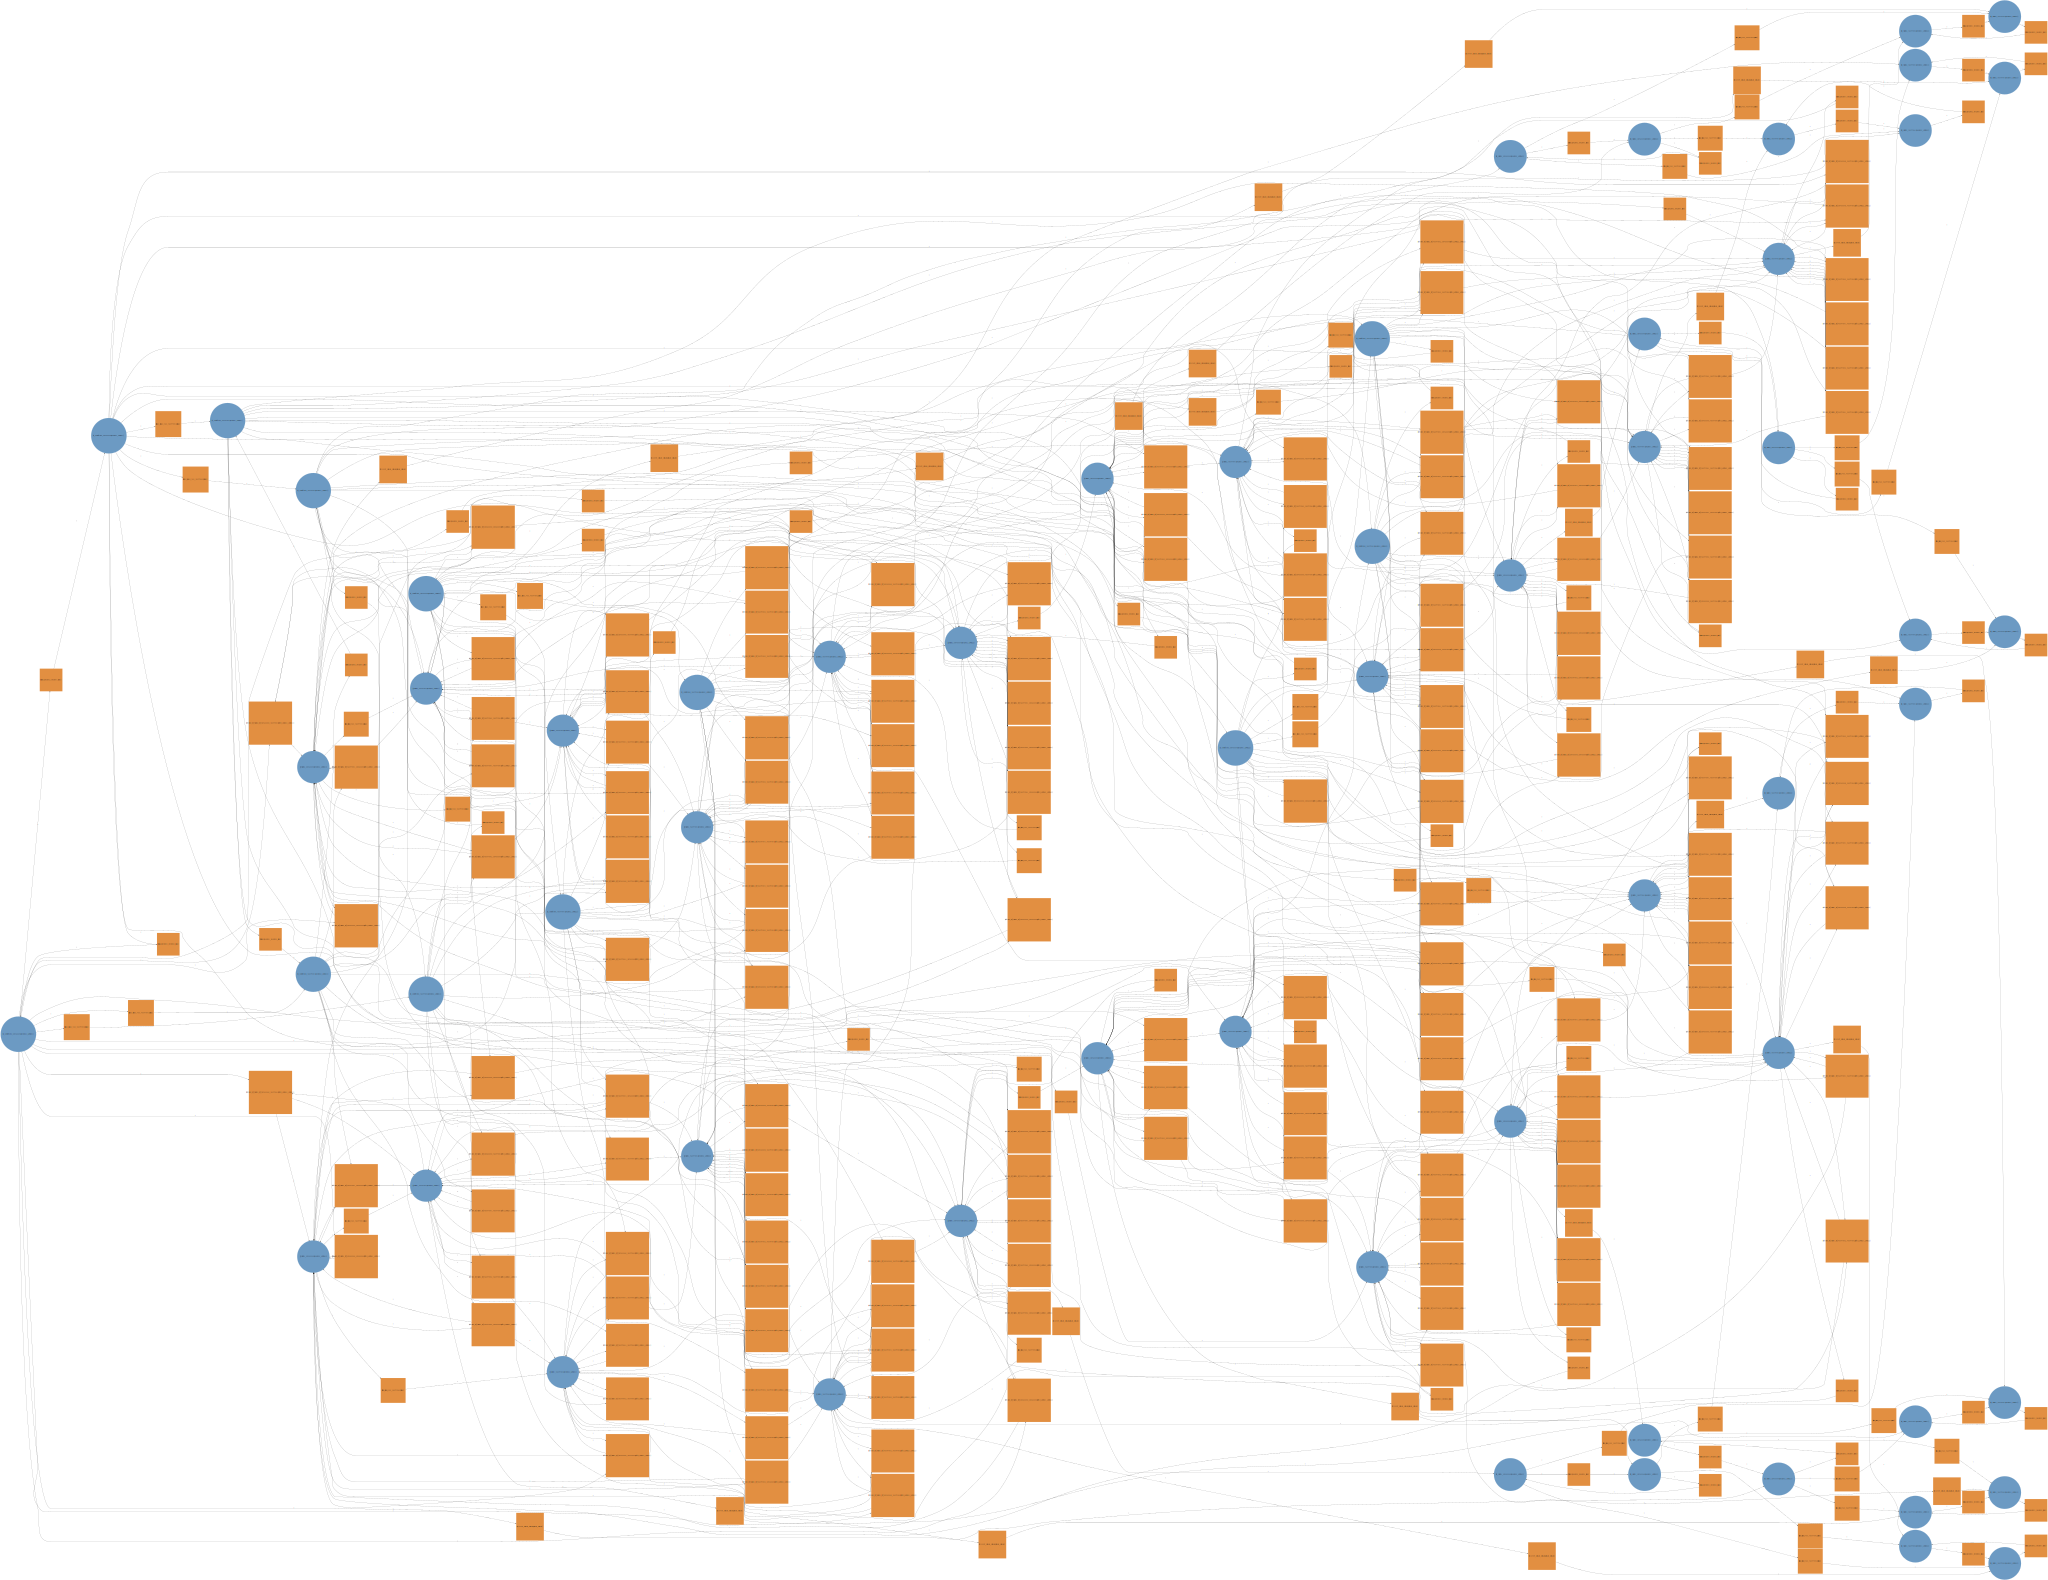

In [22]:
sir_strain_vax_trip = typed_product([aug_sir_strain_vax,aug_trip])

to_graphviz(dom(sir_strain_vax_trip))